# Homework 6

## Name : Aishwarya Donegiri

## USC ID : 4640782493

## 2. Active Learning using Support Vector Machines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## (a) Banknote Authentication Data set

In [3]:
dataset=pd.read_csv("../data/data_banknote_authentication.txt",names=['variance','skewness','curtosis','entropy','class'])
dataset

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train,X_test,y_train,y_test=train_test_split(dataset.iloc[:,:-1],dataset.iloc[:,-1],test_size=472)
print (X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(900, 4) (900,) (472, 4) (472,)


## (b) Monte Carlo Simulation with m=50

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

## i. Passive Learning

In [7]:
C_range=np.logspace(-6,3,20)
param_grid=dict(C=C_range)

M=50

In [8]:
test_error_passive=[]

for m in range(M):
    print ("M : ",m+1)

    X_train,X_test,y_train,y_test=train_test_split(dataset.iloc[:,:-1],dataset.iloc[:,-1],test_size=472)

    scalar=MinMaxScaler()
    #     scalar=StandardScaler()
    X_train=pd.DataFrame(scalar.fit_transform(X_train),columns=['variance','skewness','curtosis','entropy'])
    X_test=pd.DataFrame(scalar.transform(X_test),columns=['variance','skewness','curtosis','entropy'])
    train_dataset=pd.concat([X_train,y_train.reset_index(drop=True)],axis=1)
    train_selected=pd.DataFrame(columns=['variance','skewness','curtosis','entropy','class'])
    error=[]


    while not train_dataset.empty:
        temp=(train_dataset.sample(n=10,replace=False))

        if len(set({0,1})-set(temp.iloc[:,-1]))!=0:
            continue
        train_selected=pd.concat([train_selected,temp])
        train_dataset.drop(list(temp.index),inplace=True)

        X_train=train_selected.iloc[:,:-1]
        y_train=list(train_selected.iloc[:,-1])

        model_passive=LinearSVC(penalty='l1',dual=False,max_iter=5000)
        grid=GridSearchCV(estimator=model_passive,param_grid=param_grid,n_jobs=-1,cv=5)
        grid.fit(X_train,y_train)    
        
        y_pred=grid.predict(X_test)
        error.append(1-accuracy_score(y_test,y_pred))
        
    test_error_passive.append(error)

average_passive=np.mean(np.asarray(test_error_passive),axis=0)

M :  1
M :  2
M :  3
M :  4
M :  5
M :  6
M :  7
M :  8
M :  9
M :  10
M :  11
M :  12
M :  13
M :  14
M :  15
M :  16
M :  17
M :  18
M :  19
M :  20
M :  21
M :  22
M :  23
M :  24
M :  25
M :  26
M :  27
M :  28
M :  29
M :  30
M :  31
M :  32
M :  33
M :  34
M :  35
M :  36
M :  37
M :  38
M :  39
M :  40
M :  41
M :  42
M :  43
M :  44
M :  45
M :  46
M :  47
M :  48
M :  49
M :  50


In [9]:
pd.DataFrame({'Number of samples':range(10,901,10),"Average Error":average_passive})

,Number of samples,Average Error
0,10,0.191610
1,20,0.080212
2,30,0.050720
3,40,0.032415
4,50,0.026864
...,...,...
85,860,0.009492
86,870,0.009364
87,880,0.009364
88,890,0.009492


In [10]:
test_error_active=[]

for m in range(M):
    
    print ("M : ",m+1)
    
    X_train,X_test,y_train,y_test=train_test_split(dataset.iloc[:,:-1],dataset.iloc[:,-1],test_size=472)

    
    scalar=MinMaxScaler()
    X_train=pd.DataFrame(scalar.fit_transform(X_train),columns=['variance','skewness','curtosis','entropy'])
    X_test=pd.DataFrame(scalar.transform(X_test),columns=['variance','skewness','curtosis','entropy'])
    train_dataset=pd.concat([X_train,y_train.reset_index(drop=True)],axis=1)
    
    error=[]

    temp=(train_dataset.sample(n=10,replace=False))
    while len(set({0,1})-set(temp.iloc[:,-1]))!=0:
        temp=(train_dataset.sample(n=10,replace=False))
    
    ## model with the 10 randomly chosen points
    model_active=LinearSVC(penalty='l1',dual=False,max_iter=5000)
    grid=GridSearchCV(estimator=model_active,param_grid=param_grid,n_jobs=-1,cv=5)
    grid.fit(temp.iloc[:,:-1],temp.iloc[:,-1])
    train_selected=pd.DataFrame(temp,columns=['variance','skewness','curtosis','entropy','class'])
    train_dataset.drop(list(temp.index),inplace=True)

    y_pred=grid.predict(X_test)
    
    error.append(1-accuracy_score(y_test,y_pred))
    
    while not train_dataset.empty:
        train_dataset=train_dataset.reset_index(drop=True)
        temp=(train_dataset.sample(n=10,replace=False))

        ## finding the distances of training data points from the hyperplane
        y=grid.decision_function(train_dataset.iloc[:,:-1])
        w=np.linalg.norm(grid.best_estimator_.coef_)
        distances=np.abs(y/w)

        X_distances=pd.concat([train_dataset,pd.DataFrame({'distance':distances})],axis=1)
        train=(X_distances.sort_values(by=['distance'])).iloc[:10,:-1]
        train_selected=pd.concat([train_selected,train])  
        train_dataset.drop(list(train.index),inplace=True)    

        X_train=train_selected.iloc[:,:-1]
        y_train=list(train_selected.iloc[:,-1])

        model_active=LinearSVC(penalty='l1',dual=False,max_iter=5000)
        grid=GridSearchCV(estimator=model_active,param_grid=param_grid,n_jobs=-1,cv=5)
        grid.fit(X_train,y_train)    

        y_pred=grid.predict(X_test)
        error.append(1-accuracy_score(y_test,y_pred))

    test_error_active.append(error)

average_active=np.mean(np.asarray(test_error_active),axis=0)

M :  1
M :  2
M :  3
M :  4
M :  5
M :  6
M :  7
M :  8
M :  9
M :  10
M :  11
M :  12
M :  13
M :  14
M :  15
M :  16
M :  17
M :  18
M :  19
M :  20
M :  21
M :  22
M :  23
M :  24
M :  25
M :  26
M :  27
M :  28
M :  29
M :  30
M :  31
M :  32
M :  33
M :  34
M :  35
M :  36
M :  37
M :  38
M :  39
M :  40
M :  41
M :  42
M :  43
M :  44
M :  45
M :  46
M :  47
M :  48
M :  49
M :  50


In [11]:
pd.DataFrame({'Number of samples':range(10,901,10),"Average Error":average_active})

,Number of samples,Average Error
0,10,0.145890
1,20,0.070042
2,30,0.048475
3,40,0.027712
4,50,0.016992
...,...,...
85,860,0.012881
86,870,0.013136
87,880,0.013178
88,890,0.014195


Test Error vs Number of Training Instances


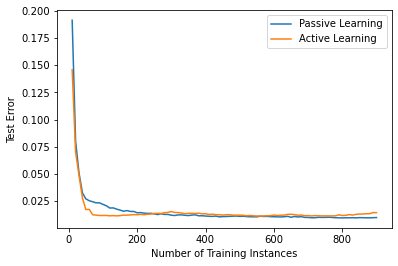

In [21]:
print ("Test Error vs Number of Training Instances")
plt.plot(range(10,901,10),average_passive,label='Passive Learning')
plt.plot(range(10,901,10),average_active,label='Active Learning')
plt.ylabel('Test Error')
plt.xlabel('Number of Training Instances')
plt.legend()

Conclusion : 
The test errors for both active and passive learning drop drastically at a point and remain constant, thereafter indicating the effect of an increase in the number of training instances. In the current dataset, both active and passive learning perform simililarly. For very few training instances, active learning does slightly better than passive learning.